In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import pycountry

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from scipy import stats
from folium.plugins import HeatMap
import plotly.express as px

import sys
import os

Описание набора данных о землетрясениях (1990-2023 гг.)

Набор данных о землетрясениях представляет собой обширную коллекцию данных, содержащую информацию обо всех землетрясениях, зарегистрированных во всем мире с 1990 по 2023 год. Набор данных состоит примерно из трех миллионов строк, каждая из которых представляет конкретное землетрясение. Каждая запись в наборе данных содержит набор соответствующих атрибутов, связанных с землетрясением, таких как дата и время события, географическое положение (широта и долгота), магнитуда землетрясения, глубина эпицентра, тип землетрясения. величина, используемая для измерения, затронутый регион и другая соответствующая информация.

Описание датасета:
- time - время в милисекундах.
- place - географическое положение.
- status - представляет текущее состояние или условие события, которое может быть просмотрено или автоматически определено.
- tsunami (boolean value) - относится к серии больших океанских волн, обычно вызываемых подводными волнениями, часто связанными с землетрясениями.
- significance - обозначает важность или уровень воздействия события, которое можно использовать для оценки потенциальных последствий.
- data_type - указывает тип данных.
- magnitudo - относится к измерению размера или интенсивности землетрясения, обычно измеряемого по шкале Рихтера.
- state - представляет административную единицу или штат, где произошло событие.
- longitude - долгота.
- latitude - широта.
- depth - глубина землетрясения.
- date - дата и время землетрясения.

In [30]:
df = pd.read_csv('../data/Earthquakes-1990-2023.csv')

In [31]:
# берем сэмпл 120 000 строк
df = df[-50000:]

In [32]:
# просмотр датасета
df[:5]

time                               place    status  tsunami  \
3395751  1679500605010                          Washington  reviewed        0   
3395752  1679500834663  86 km WSW of El Aguilar, Argentina  reviewed        0   
3395753  1679501093539        39 km NNE of Chenega, Alaska  reviewed        0   
3395754  1679501240390      38 km E of Port Heiden, Alaska  reviewed        0   
3395755  1679501332450              9km N of Idyllwild, CA  reviewed        0   

         significance   data_type  magnitude       state   longitude  \
3395751             1  earthquake       0.25  Washington -121.940833   
3395752           641  earthquake       6.40   Argentina  -66.495400   
3395753            44  earthquake       1.70      Alaska -147.822100   
3395754            84  earthquake       2.33      Alaska -158.008333   
3395755            50  earthquake       1.80  California -116.737000   

          latitude   depth                              date  
3395751  46.815333    8.65  2023-03-22 15:56:45.010000+00:00  
3395752 -23.422400  228.00  2023-03-22 16:00:34.663000+00:00  
3395753  60.411700   10.10  2023-03-22 16:04:53.539000+00:00  
3395754  56.905333   -0.91  2023-03-22 16:07:20.390000+00:00  
3395755  33.821000   12.54  2023-03-22 16:08:52.450000+00:00

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 3395751 to 3445750
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          50000 non-null  int64  
 1   place         50000 non-null  object 
 2   status        50000 non-null  object 
 3   tsunami       50000 non-null  int64  
 4   significance  50000 non-null  int64  
 5   data_type     50000 non-null  object 
 6   magnitude     50000 non-null  float64
 7   state         50000 non-null  object 
 8   longitude     50000 non-null  float64
 9   latitude      50000 non-null  float64
 10  depth         50000 non-null  float64
 11  date          50000 non-null  object 
dtypes: float64(4), int64(3), object(5)
memory usage: 4.6+ MB


In [34]:
# перенаименоване столбца time в корректное название milliseconds
df = df.rename(columns={'time': 'milliseconds'})

# перенаименоване столбца date в datetime
df = df.rename(columns={'date': 'datetime'})

# перенаименоване столбца state в country
df = df.rename(columns={'state': 'country'})

# отделение часового пояса из столбца datetime в новый столбец timezone
df['timezone'] = df['datetime'].str.extract(r'(\+\S+$)')

# удаление часового пояса из столбца date
df['datetime'] = df['datetime'].str.replace(r'\+\S+$', '', regex=True)

# удаление милисекунд в столбце datetime
df['datetime'] = df['datetime'].str.split('.').str[0]

# преобразуем столбец datetime в формат datetime64[ns]
df['datetime'] = pd.to_datetime(df['datetime'])

# Разделяем столбец 'datetime' на дату и время
#df[['date', 'time']] = df['datetime'].str.split(' ', expand=True)

## дропаем datetime после разделения на date и time
#df = df.drop('datetime', axis=1)

# преобразуем столбцы date и time в формат datetime64[ns]
#df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
#df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')

In [35]:
"""Из-за присутствия в одном столбце нзвания штатов Америки и названия стран, необходимо поменять названия штатов на название страны USA"""
# удаляем лишние символы перед наименованием страны для будущей замены
df['country'] = df['country'].str.strip()

# лист с названиями штатов
us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
             'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
             'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 
             'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 
             'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 
             'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 
             'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'south of Alaska']

# меняем названия штатов на USA
df['country'] = df['country'].apply(lambda country: 'USA' if any(state in country for state in us_states) else country)

In [36]:
# просматриваем что названия штатов поменялись на USA
df['country'].unique()

array(['USA', 'Argentina', 'Mid-Indian Ridge', 'Aleutian Islands',
       'Turkey', 'Tajikistan', 'Indonesia', 'Tanzania', 'Taiwan',
       'Puerto Rico', 'Australia', 'Philippines', 'Papua New Guinea',
       'Albania', 'Costa Rica', 'South Sandwich Islands region',
       'Kyrgyzstan', 'Fiji', 'West Chile Rise', 'New Zealand', 'Peru',
       'Chile', 'Solomon Islands', 'Afghanistan', 'China', 'Timor Leste',
       'B.C.', 'Russia', 'Kermadec Islands region', 'Japan region',
       'east central Pacific Ocean', 'Canada', 'Banda Sea', 'Iran',
       'India region', 'Greece', 'Nepal', 'Tonga', 'Azerbaijan', 'Japan',
       'near the coast of Guatemala', 'Mexico',
       'northern Mid-Atlantic Ridge', 'U.S. Virgin Islands',
       'Puerto Rico region', 'Tunisia',
       'Saint Vincent and the Grenadines', 'Myanmar', 'Fiji region',
       'Vanuatu region', 'Vanuatu', 'Virgin Islands',
       'central Mid-Atlantic Ridge', 'Pakistan', 'Mona Passage',
       'Dominican Republic', 'Mongolia',

In [37]:
# просмотр количества стран
len(df['country'].unique())

257

In [38]:
# удаление слова "earthquake"
df['country'] = df['country'].str.replace('earthquake', '')

# удаление слова "Earthquake"
df['country'] = df['country'].str.replace('Earthquake', '')

# удаление слова "sequence"
df['country'] = df['country'].str.replace('sequence', '')

# удаление слова "Sequence"
df['country'] = df['country'].str.replace('Sequence', '')

# удаление слова "region"
df['country'] = df['country'].str.replace('region', '')

# удаление в столбце df['country'], лишних пробелов перед названием страны и после названия страны
df['country'] = df['country'].str.strip()

In [39]:
# получение списка стран
countries = [country.name for country in pycountry.countries]

# замена названий стран из списка countries
df['country'] = df['country'].map(lambda x: next((country for country in countries if country in x), x))
len(df['country'].unique())

195

In [40]:
# просматриваем после замены названий стран
df['country'].unique()

array(['USA', 'Argentina', 'India', 'Aleutian Islands', 'Turkey',
       'Tajikistan', 'Indonesia', 'Tanzania', 'Taiwan', 'Puerto Rico',
       'Australia', 'Philippines', 'Guinea', 'Albania', 'Costa Rica',
       'South Sandwich Islands', 'Kyrgyzstan', 'Fiji', 'Chile',
       'New Zealand', 'Peru', 'Solomon Islands', 'Afghanistan', 'China',
       'Timor Leste', 'B.C.', 'Russia', 'Kermadec Islands', 'Japan',
       'east central Pacific Ocean', 'Canada', 'Banda Sea', 'Iran',
       'Greece', 'Nepal', 'Tonga', 'Azerbaijan', 'Guatemala', 'Mexico',
       'northern Mid-Atlantic Ridge', 'U.S. Virgin Islands', 'Tunisia',
       'Saint Vincent and the Grenadines', 'Myanmar', 'Vanuatu',
       'Virgin Islands', 'central Mid-Atlantic Ridge', 'Pakistan',
       'Mona Passage', 'Dominica', 'Mongolia', 'Colombia',
       'southeast of the Loyalty Islands', 'El Salvador', 'Guam', 'Samoa',
       'Congo', 'Southern Iran', 'near the coast of Venezuela',
       'south of the Kermadec Islands', 'Ital

In [41]:
# просмотр датасета
df[:5]

milliseconds                               place    status  tsunami  \
3395751  1679500605010                          Washington  reviewed        0   
3395752  1679500834663  86 km WSW of El Aguilar, Argentina  reviewed        0   
3395753  1679501093539        39 km NNE of Chenega, Alaska  reviewed        0   
3395754  1679501240390      38 km E of Port Heiden, Alaska  reviewed        0   
3395755  1679501332450              9km N of Idyllwild, CA  reviewed        0   

         significance   data_type  magnitude    country   longitude  \
3395751             1  earthquake       0.25        USA -121.940833   
3395752           641  earthquake       6.40  Argentina  -66.495400   
3395753            44  earthquake       1.70        USA -147.822100   
3395754            84  earthquake       2.33        USA -158.008333   
3395755            50  earthquake       1.80        USA -116.737000   

          latitude   depth            datetime timezone  
3395751  46.815333    8.65 2023-03-22 15:56:45   +00:00  
3395752 -23.422400  228.00 2023-03-22 16:00:34   +00:00  
3395753  60.411700   10.10 2023-03-22 16:04:53   +00:00  
3395754  56.905333   -0.91 2023-03-22 16:07:20   +00:00  
3395755  33.821000   12.54 2023-03-22 16:08:52   +00:00

In [42]:
# общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 3395751 to 3445750
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   milliseconds  50000 non-null  int64         
 1   place         50000 non-null  object        
 2   status        50000 non-null  object        
 3   tsunami       50000 non-null  int64         
 4   significance  50000 non-null  int64         
 5   data_type     50000 non-null  object        
 6   magnitude     50000 non-null  float64       
 7   country       50000 non-null  object        
 8   longitude     50000 non-null  float64       
 9   latitude      50000 non-null  float64       
 10  depth         50000 non-null  float64       
 11  datetime      50000 non-null  datetime64[ns]
 12  timezone      50000 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 5.0+ MB


In [43]:
# просмотр пропусков
df.isna().sum()

milliseconds    0
place           0
status          0
tsunami         0
significance    0
data_type       0
magnitude       0
country         0
longitude       0
latitude        0
depth           0
datetime        0
timezone        0
dtype: int64

In [44]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

tsunami  significance     magnitude     longitude      latitude  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.000780     59.644480      1.531292   -118.420568     42.369345   
min        0.000000      0.000000     -1.590000   -179.998700    -65.210500   
25%        0.000000      9.000000      0.780000   -155.099500     34.524692   
50%        0.000000     26.000000      1.300000   -122.976583     40.470333   
75%        0.000000     62.000000      2.000000   -116.736167     58.248175   
max        1.000000   1072.000000      7.700000    179.999400     86.593900   
std        0.027918     91.103656      1.231750     70.167709     19.819208   

              depth                       datetime  
count  50000.000000                          50000  
mean      24.827801  2023-05-24 06:34:01.998759936  
min       -3.440000            2023-03-22 15:56:45  
25%        2.770000  2023-04-22 15:51:02.249999872  
50%        8.160000            2023-05-23 00:06:08  
75%       20.970000  2023-06-25 08:15:02.750000128  
max      681.238000            2023-07-29 11:08:57  
std       53.608048                            NaN

In [45]:
# основные описательные статистики для булевых и категориальных признаков
df.describe(include=["object", "bool"])

place    status   data_type country timezone
count                        50000     50000       50000   50000    50000
unique                       20347         2           8     195        1
top     85 km NW of Karluk, Alaska  reviewed  earthquake     USA   +00:00
freq                           836     44898       48809   43327    50000

In [46]:
# удаляем строки с отрицательными значениями магнитуды
df = df[df['magnitude'] >= 0]

# основные описательные статистики для числовых признаков после удаления отрицатльных значений магнитуды
df.iloc[:, 1:].describe()

tsunami  significance     magnitude     longitude      latitude  \
count  46699.000000  46699.000000  46699.000000  46699.000000  46699.000000   
mean       0.000835     63.860532      1.663338   -116.184662     41.477024   
min        0.000000      0.000000      0.000000   -179.998700    -65.210500   
25%        0.000000     12.000000      0.900000   -153.251950     34.001167   
50%        0.000000     30.000000      1.390000   -122.819667     38.899900   
75%        0.000000     63.000000      2.030000   -116.585500     58.237767   
max        1.000000   1072.000000      7.700000    179.999400     86.593900   
std        0.028887     92.829608      1.164436     71.863359     20.118682   

              depth                       datetime  
count  46699.000000                          46699  
mean      26.301094  2023-05-24 01:43:11.153622016  
min       -3.440000            2023-03-22 15:56:45  
25%        3.200000     2023-04-22 08:10:32.500000  
50%        9.000000            2023-05-22 13:04:21  
75%       25.300000     2023-06-25 06:48:10.500000  
max      681.238000            2023-07-29 11:08:57  
std       55.148630                            NaN

In [47]:
# создание карты с магнитудой
fig = px.scatter_geo(df, lat='latitude', lon='longitude',
                     color='magnitude', color_continuous_scale='reds',
                     hover_name='place', #size='magnitude',
                     title='Earthquakes Around the World')

fig.update_layout(
    geo=dict(
        landcolor='white',
        oceancolor='lightblue',
        showland=True,
        showocean=True,
    ),
    width=1200,  
    height=800,  
)

fig.show()

In [48]:
# # создание объекта карты
# mapObj = folium.Map([31.989210327459197, -44.07763413369443], zoom_start=3)

# # добавление тепловой карты на объект
# heatmap = folium.plugins.HeatMap(data=df[['latitude', 'longitude']].values.tolist(), radius=12)
# heatmap.add_to(mapObj)

# # отображение карты
# mapObj

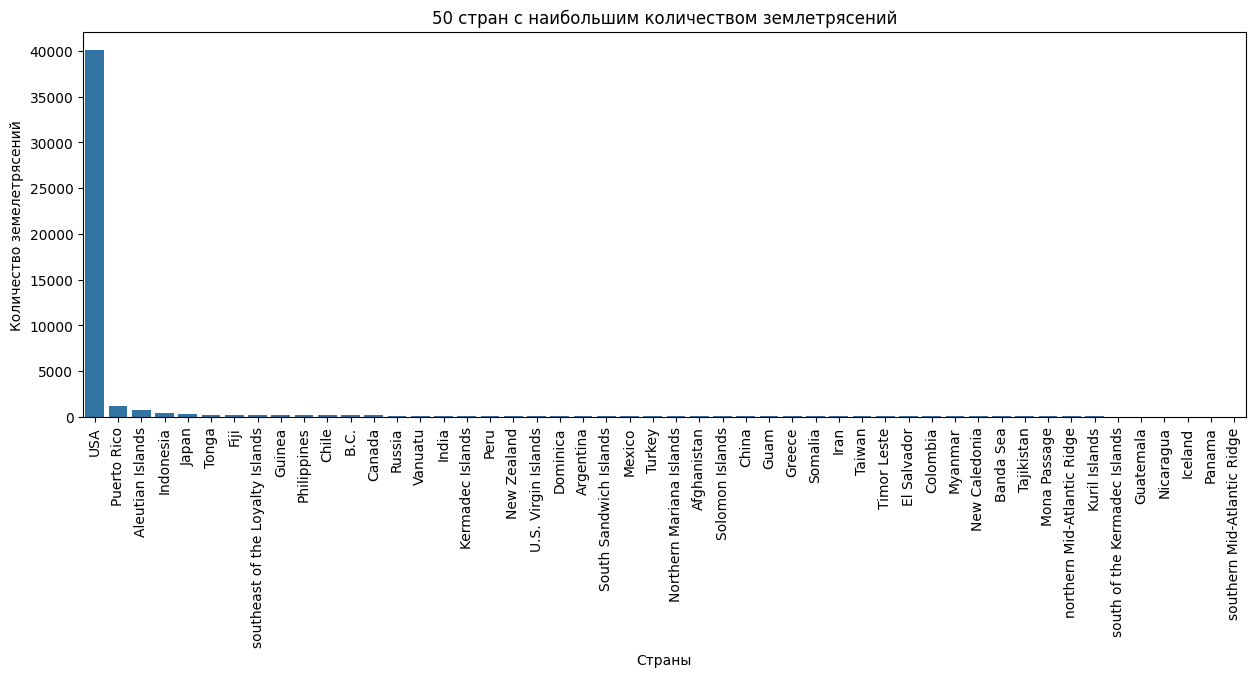

In [49]:
# подсчёт количества землетрясений в странах
counts = df['country'].value_counts()

# отображение первых 50 стран
plt.figure(figsize=(15, 5))
sns.barplot(x=counts.head(50).index, y=counts.head(50).values)
plt.xlabel('Страны')
plt.ylabel('Количество земелетрясений')
plt.title('50 стран с наибольшим количеством землетрясений')
plt.xticks(rotation=90)
plt.show()


Из-за большого количества земтретрясений в USA, для анализа посмотрим страны без USA.

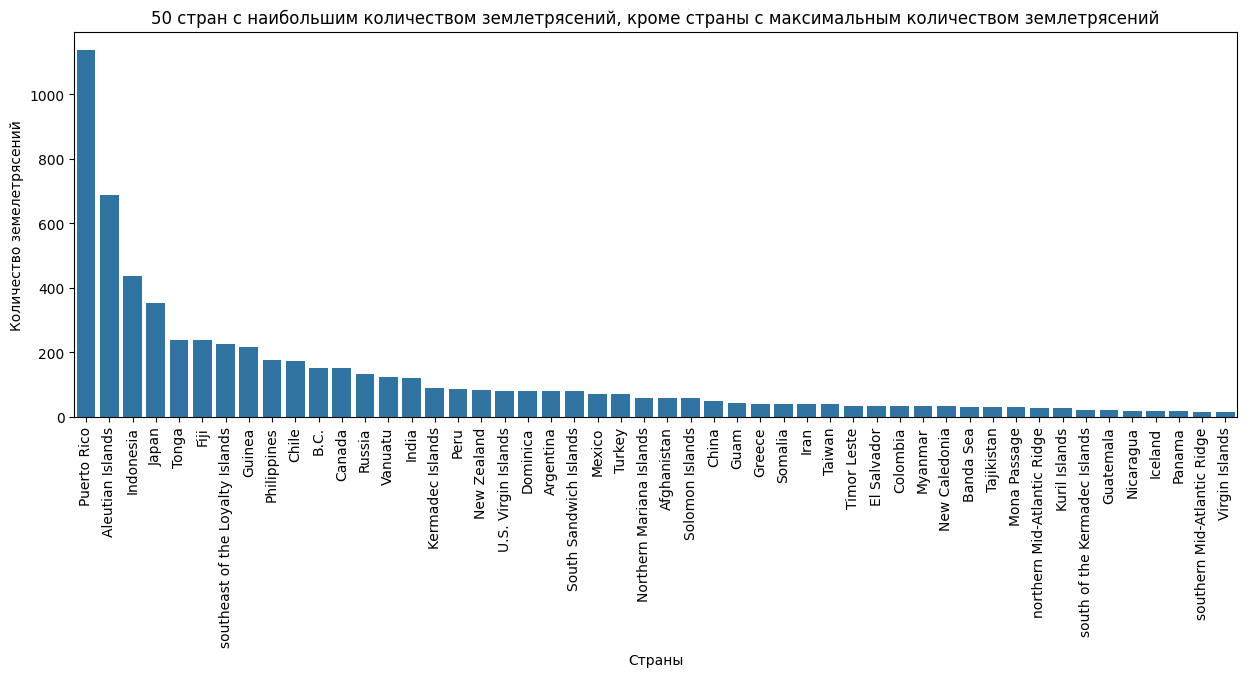

In [50]:
# отображение первых 50 стран, кроме USA
plt.figure(figsize=(15, 5))
sns.barplot(x=counts.iloc[1:51].index, y=counts.iloc[1:51].values)
plt.xlabel('Страны')
plt.ylabel('Количество земелетрясений')
plt.title('50 стран с наибольшим количеством землетрясений, кроме страны с максимальным количеством землетрясений')
plt.xticks(rotation=90)
plt.show()

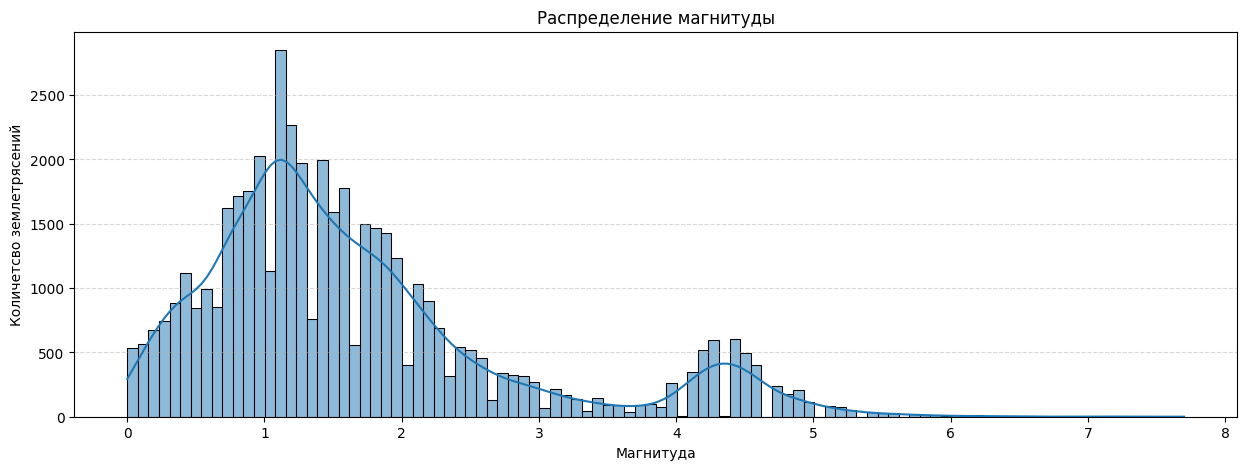

In [51]:
# просмотрим распределения магнитуды
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x='magnitude', kde=True, bins=100, edgecolor='black')
plt.title('Распределение магнитуды')
plt.xlabel('Магнитуда')
plt.ylabel('Количетсво землетрясений')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


In [52]:
def get_bins_magnitude(data: int) -> str:
    """
    Генерация бинов для землетрясений"
    """
    if isinstance(data, (int, float)):
        if data <= 3:
            return 'green'
        elif 3 < data <= 5:
            return 'orange'
        elif data > 5:
            return 'red'

In [53]:
# генерация бинов, для будущей отрисовки прогноза на карте
df['magnitude_bins'] = df['magnitude'].apply(get_bins_magnitude)

In [54]:
# разделение datetime64[ns] по столбцам для будущего обучения моделей
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

In [55]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

In [56]:
df.shape

(46699, 20)